In [1]:
#import packages
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import cinemaot as co
from anndata import AnnData

/opt/homebrew/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:185: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/opt/homebrew/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:261: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/Users/guardian/Desktop/CINEMA-OT/cinemaot/benchmark.py:15: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [2]:
#Functions for evaluation
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

def preprocessing(i):
    adata = sc.read_csv('SplatterBenchmarkData2/SpData'+str(i)+'.csv')
    adata.obs_names_make_unique()
    adata = AnnData.transpose(adata)
    groups = pd.read_csv('SplatterBenchmarkData2/Treatment'+str(i)+'.csv')
    states = pd.read_csv('SplatterBenchmarkData2/CellState'+str(i)+'.csv')
    steps = pd.read_csv('SplatterBenchmarkData2/PathStep'+str(i)+'.csv')
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    adata.obs['groups'] = pd.Series(groups['x'].values, dtype="category").values
    adata.obs['states'] = pd.Series(states['x'].values, dtype="category").values
    adata.obs['steps'] = steps['x'].values
    sc.pp.pca(adata)
    return adata

def groundtruth(adata,i):
    adata1 = adata[adata.obs['groups']=='Group1',:]
    adata2 = adata[adata.obs['groups']=='Group2',:]
    
    gtmatrix = np.zeros([adata2.X.shape[0],adata1.X.shape[0]])
    gtmatrix2 = np.zeros([adata2.X.shape[0],adata1.X.shape[0]])
    states1 = adata.obs['states'].values[adata.obs['groups']=='Group1']
    states2 = adata.obs['states'].values[adata.obs['groups']=='Group2']
    for state in adata.obs['states'].cat.categories.values:
        adata1_ = adata1[adata1.obs['states']==state,:]
        adata2_ = adata2[adata2.obs['states']==state,:]
        steps1 = adata1_.obs['steps'].values
        steps2 = adata2_.obs['steps'].values
        nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(steps1.reshape(-1, 1))
        tmpmatrix = nbrs.kneighbors_graph(steps2.reshape(-1, 1)).toarray()
        tmpmatrix2 = np.ones_like(tmpmatrix)
        
        tmp2 = (states2==state)
        tmp1 = (states1==state)
        tmp4 = np.arange(tmp2.shape[0])
        tmp3 = np.arange(tmp1.shape[0])
        tmp4 = tmp4[tmp2]
        tmp3 = tmp3[tmp1]
        gtmatrix[tmp4[:,None],tmp3] = tmpmatrix
        gtmatrix2[tmp4[:,None],tmp3] = tmpmatrix2

    gtdata = pd.read_csv('SplatterBenchmarkData2/GT'+str(i)+'.csv').values[:,1:].T
    gtadata = sc.AnnData(gtdata)
    sc.pp.normalize_total(gtadata)
    sc.pp.log1p(gtadata)
    
    s2 = adata.obs['groups']=='Group2'
    s1 = adata.obs['groups']=='Group1'
    #te2 = np.mean(gtdata[:,s2.values],axis=1) - np.mean(gtdata[:,s1.values],axis=1)
    #te2 = np.repeat(te2[:,None],round(np.sum(s2.values)),axis=1).T
    te2 = adata.X[adata.obs['groups']=='Group2',:] - np.matmul(gtmatrix2/np.sum(gtmatrix2,axis=1)[:,None],adata.X[adata.obs['groups']=='Group1',:])
    return gtmatrix, te2

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
#Evaluation of mixscape
auc_mixscape = np.zeros(15)
corr_mixscape = np.zeros(15)
scorr_mixscape = np.zeros(15)

for i in range(1,16):
    adata = preprocessing(i)
    gtmatching, gite = groundtruth(adata,i)
    signal, matching, ite = co.benchmark.mixscape(adata,'groups','Group2','Group1')
    auc_mixscape[i-1], corr_mixscape[i-1],scorr_mixscape[i-1] = co.benchmark.evaluate_cinema(matching,ite,gtmatching,gite)
    #auc_mixscape.append(auc_mixscape_)
    #corr_mixscape.append(corr_mixscape_)
    #scorr_mixscape.append(scorr_mixscape_)
    if i == 1:
        metrics_mixscape = co.benchmark.evaluate_batch(signal,adata,'groups',['states','steps'],[False,True])
    else:
        metrics_mixscape = pd.concat([metrics_mixscape,co.benchmark.evaluate_batch(signal,adata,'groups',['states','steps'],[False,True])], axis = 1)
    if i == 1:
        metrics_mixscape2 = co.benchmark.evaluate_batch(signal,adata,'groups',['states','steps'],[False,True])
    else:
        metrics_mixscape2 = pd.concat([metrics_mixscape2,co.benchmark.evaluate_batch(signal,adata,'states',['groups','steps'],[False,True])], axis = 1)
        
metrics_mixscape.columns = np.arange(15)

Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Variance contribution increased after integration

In [5]:
auc_harmony = np.zeros(15)
corr_harmony = np.zeros(15)
scorr_harmony = np.zeros(15)

for i in range(1,16):
    adata = preprocessing(i)
    gtmatching, gite = groundtruth(adata,i)
    signal, matching, ite = co.benchmark.harmony_mixscape(adata,'groups','Group2','Group1')
    auc_harmony[i-1], corr_harmony[i-1],scorr_harmony[i-1] = co.benchmark.evaluate_cinema(matching,ite,gtmatching,gite)
    #auc_harmony.append(auc_harmony_)
    #corr_harmony.append(corr_harmony_)
    #scorr_harmony.append(scorr_harmony_)
    if i == 1:
        metrics_harmony = co.benchmark.evaluate_batch(signal,adata,'groups',['states','steps'],[False,True])
    else:
        metrics_harmony = pd.concat([metrics_harmony,co.benchmark.evaluate_batch(signal,adata,'groups',['states','steps'],[False,True])], axis = 1)
    if i == 1:
        metrics_harmony2 = co.benchmark.evaluate_batch(signal,adata,'states',['groups','steps'],[False,True])
    else:
        metrics_harmony2 = pd.concat([metrics_harmony2,co.benchmark.evaluate_batch(signal,adata,'states',['groups','steps'],[False,True])], axis = 1)
        
metrics_harmony.columns = np.arange(15)

2022-07-12 20:12:31,010 - harmonypy - INFO - Iteration 1 of 10
2022-07-12 20:12:31,105 - harmonypy - INFO - Iteration 2 of 10
2022-07-12 20:12:31,194 - harmonypy - INFO - Iteration 3 of 10
2022-07-12 20:12:31,277 - harmonypy - INFO - Converged after 3 iterations


Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...
Graph connectivity...


2022-07-12 20:12:34,965 - harmonypy - INFO - Iteration 1 of 10
2022-07-12 20:12:35,097 - harmonypy - INFO - Iteration 2 of 10
2022-07-12 20:12:35,191 - harmonypy - INFO - Iteration 3 of 10
2022-07-12 20:12:35,268 - harmonypy - INFO - Iteration 4 of 10
2022-07-12 20:12:35,336 - harmonypy - INFO - Iteration 5 of 10
2022-07-12 20:12:35,370 - harmonypy - INFO - Converged after 5 iterations


Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...
Graph connectivity...


2022-07-12 20:12:39,103 - harmonypy - INFO - Iteration 1 of 10
2022-07-12 20:12:39,189 - harmonypy - INFO - Iteration 2 of 10
2022-07-12 20:12:39,287 - harmonypy - INFO - Iteration 3 of 10
2022-07-12 20:12:39,391 - harmonypy - INFO - Iteration 4 of 10
2022-07-12 20:12:39,418 - harmonypy - INFO - Iteration 5 of 10
2022-07-12 20:12:39,460 - harmonypy - INFO - Converged after 5 iterations


Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...
Graph connectivity...


2022-07-12 20:12:42,596 - harmonypy - INFO - Iteration 1 of 10
2022-07-12 20:12:42,719 - harmonypy - INFO - Iteration 2 of 10
2022-07-12 20:12:42,796 - harmonypy - INFO - Iteration 3 of 10
2022-07-12 20:12:42,869 - harmonypy - INFO - Converged after 3 iterations


Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...
Graph connectivity...


2022-07-12 20:12:45,837 - harmonypy - INFO - Iteration 1 of 10
2022-07-12 20:12:45,935 - harmonypy - INFO - Iteration 2 of 10
2022-07-12 20:12:46,026 - harmonypy - INFO - Iteration 3 of 10
2022-07-12 20:12:46,090 - harmonypy - INFO - Converged after 3 iterations


Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...


2022-07-12 20:12:49,143 - harmonypy - INFO - Iteration 1 of 10
2022-07-12 20:12:49,212 - harmonypy - INFO - Iteration 2 of 10
2022-07-12 20:12:49,312 - harmonypy - INFO - Iteration 3 of 10
2022-07-12 20:12:49,373 - harmonypy - INFO - Iteration 4 of 10
2022-07-12 20:12:49,450 - harmonypy - INFO - Iteration 5 of 10
2022-07-12 20:12:49,522 - harmonypy - INFO - Converged after 5 iterations


Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...
Graph connectivity...


2022-07-12 20:12:52,278 - harmonypy - INFO - Iteration 1 of 10
2022-07-12 20:12:52,355 - harmonypy - INFO - Iteration 2 of 10
2022-07-12 20:12:52,430 - harmonypy - INFO - Iteration 3 of 10
2022-07-12 20:12:52,478 - harmonypy - INFO - Converged after 3 iterations


Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...
Graph connectivity...


2022-07-12 20:12:55,391 - harmonypy - INFO - Iteration 1 of 10
2022-07-12 20:12:55,471 - harmonypy - INFO - Iteration 2 of 10
2022-07-12 20:12:55,572 - harmonypy - INFO - Iteration 3 of 10
2022-07-12 20:12:55,637 - harmonypy - INFO - Iteration 4 of 10
2022-07-12 20:12:55,701 - harmonypy - INFO - Iteration 5 of 10
2022-07-12 20:12:55,753 - harmonypy - INFO - Iteration 6 of 10
2022-07-12 20:12:55,805 - harmonypy - INFO - Iteration 7 of 10
2022-07-12 20:12:55,839 - harmonypy - INFO - Converged after 7 iterations


Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...
Graph connectivity...


2022-07-12 20:12:58,890 - harmonypy - INFO - Iteration 1 of 10
2022-07-12 20:12:58,964 - harmonypy - INFO - Iteration 2 of 10
2022-07-12 20:12:59,042 - harmonypy - INFO - Iteration 3 of 10
2022-07-12 20:12:59,107 - harmonypy - INFO - Iteration 4 of 10
2022-07-12 20:12:59,211 - harmonypy - INFO - Iteration 5 of 10
2022-07-12 20:12:59,278 - harmonypy - INFO - Iteration 6 of 10
2022-07-12 20:12:59,303 - harmonypy - INFO - Iteration 7 of 10
2022-07-12 20:12:59,352 - harmonypy - INFO - Iteration 8 of 10
2022-07-12 20:12:59,403 - harmonypy - INFO - Converged after 8 iterations


Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...
Graph connectivity...


2022-07-12 20:13:02,669 - harmonypy - INFO - Iteration 1 of 10
2022-07-12 20:13:02,754 - harmonypy - INFO - Iteration 2 of 10
2022-07-12 20:13:02,838 - harmonypy - INFO - Iteration 3 of 10
2022-07-12 20:13:02,901 - harmonypy - INFO - Iteration 4 of 10
2022-07-12 20:13:02,941 - harmonypy - INFO - Iteration 5 of 10
2022-07-12 20:13:02,978 - harmonypy - INFO - Iteration 6 of 10
2022-07-12 20:13:03,025 - harmonypy - INFO - Iteration 7 of 10
2022-07-12 20:13:03,086 - harmonypy - INFO - Iteration 8 of 10
2022-07-12 20:13:03,120 - harmonypy - INFO - Converged after 8 iterations


Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...
Graph connectivity...


2022-07-12 20:13:06,062 - harmonypy - INFO - Iteration 1 of 10
2022-07-12 20:13:06,172 - harmonypy - INFO - Iteration 2 of 10
2022-07-12 20:13:06,259 - harmonypy - INFO - Iteration 3 of 10
2022-07-12 20:13:06,296 - harmonypy - INFO - Iteration 4 of 10
2022-07-12 20:13:06,368 - harmonypy - INFO - Iteration 5 of 10
2022-07-12 20:13:06,398 - harmonypy - INFO - Iteration 6 of 10
2022-07-12 20:13:06,451 - harmonypy - INFO - Iteration 7 of 10
2022-07-12 20:13:06,477 - harmonypy - INFO - Iteration 8 of 10
2022-07-12 20:13:06,520 - harmonypy - INFO - Converged after 8 iterations


Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...
Graph connectivity...


2022-07-12 20:13:09,934 - harmonypy - INFO - Iteration 1 of 10
2022-07-12 20:13:10,015 - harmonypy - INFO - Iteration 2 of 10
2022-07-12 20:13:10,108 - harmonypy - INFO - Iteration 3 of 10
2022-07-12 20:13:10,175 - harmonypy - INFO - Iteration 4 of 10
2022-07-12 20:13:10,205 - harmonypy - INFO - Iteration 5 of 10
2022-07-12 20:13:10,236 - harmonypy - INFO - Converged after 5 iterations


Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...
Graph connectivity...


2022-07-12 20:13:13,846 - harmonypy - INFO - Iteration 1 of 10
2022-07-12 20:13:13,938 - harmonypy - INFO - Iteration 2 of 10
2022-07-12 20:13:14,019 - harmonypy - INFO - Iteration 3 of 10
2022-07-12 20:13:14,119 - harmonypy - INFO - Iteration 4 of 10
2022-07-12 20:13:14,189 - harmonypy - INFO - Iteration 5 of 10
2022-07-12 20:13:14,229 - harmonypy - INFO - Iteration 6 of 10
2022-07-12 20:13:14,263 - harmonypy - INFO - Converged after 6 iterations


Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...
Graph connectivity...


2022-07-12 20:13:18,258 - harmonypy - INFO - Iteration 1 of 10
2022-07-12 20:13:18,330 - harmonypy - INFO - Iteration 2 of 10
2022-07-12 20:13:18,371 - harmonypy - INFO - Iteration 3 of 10
2022-07-12 20:13:18,421 - harmonypy - INFO - Iteration 4 of 10
2022-07-12 20:13:18,452 - harmonypy - INFO - Iteration 5 of 10
2022-07-12 20:13:18,495 - harmonypy - INFO - Converged after 5 iterations


Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...
Graph connectivity...


2022-07-12 20:13:23,581 - harmonypy - INFO - Iteration 1 of 10
2022-07-12 20:13:23,720 - harmonypy - INFO - Iteration 2 of 10
2022-07-12 20:13:23,858 - harmonypy - INFO - Iteration 3 of 10
2022-07-12 20:13:23,921 - harmonypy - INFO - Converged after 3 iterations


Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...
Graph connectivity...


In [6]:
auc_OT = np.zeros(15)
corr_OT = np.zeros(15)
scorr_OT = np.zeros(15)

for i in range(1,16):
    adata = preprocessing(i)
    gtmatching, gite = groundtruth(adata,i)
    signal, matching, ite = co.benchmark.OT(adata,'groups','Group2','Group1',thres=0.2)
    auc_OT[i-1], corr_OT[i-1], scorr_OT[i-1] = co.benchmark.evaluate_cinema(matching,ite,gtmatching,gite)
    #auc_OT.append(auc_OT_)
    #corr_OT.append(corr_OT_)
    #scorr_OT.append(scorr_OT_)
    if i == 1:
        metrics_OT = co.benchmark.evaluate_batch(signal,adata,'groups',['states','steps'],[False,True])
    else:
        metrics_OT = pd.concat([metrics_OT,co.benchmark.evaluate_batch(signal,adata,'groups',['states','steps'],[False,True])], axis = 1)
    if i == 1:
        metrics_OT2 = co.benchmark.evaluate_batch(signal,adata,'states',['groups','steps'],[False,True])
    else:
        metrics_OT2 = pd.concat([metrics_OT2,co.benchmark.evaluate_batch(signal,adata,'states',['groups','steps'],[False,True])], axis = 1)
        
metrics_OT.columns = np.arange(15)

Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...
Graph connectivity...


In [7]:
auc_cinemaot = np.zeros(15)
corr_cinemaot = np.zeros(15)
scorr_cinemaot = np.zeros(15)

for i in range(1,16):
    adata = preprocessing(i)
    gtmatching, gite = groundtruth(adata,i)
    signal, matching, ite = co.cinemaot.cinemaot_unweighted(adata,obs_label='groups', ref_label='Group2', expr_label='Group1',mode='parametric',dim=None,thres=0.5,eps=1e-3,smoothness=5e-4)
    auc_cinemaot[i-1], corr_cinemaot[i-1],scorr_cinemaot[i-1] = co.benchmark.evaluate_cinema(matching,ite,gtmatching,gite)
    #auc_cinemaot.append(auc_cinemaot_)
    #corr_cinemaot.append(corr_cinemaot_)
    #scorr_cinemaot.append(scorr_cinemaot_)
    if i == 1:
        metrics_cinemaot = co.benchmark.evaluate_batch(signal,adata,'groups',['states','steps'],[False,True])
    else:
        metrics_cinemaot = pd.concat([metrics_cinemaot,co.benchmark.evaluate_batch(signal,adata,'groups',['states','steps'],[False,True])], axis = 1)
    if i == 1:
        metrics_cinemaot2 = co.benchmark.evaluate_batch(signal,adata,'states',['groups','steps'],[False,True])
    else:
        metrics_cinemaot2 = pd.concat([metrics_cinemaot2,co.benchmark.evaluate_batch(signal,adata,'states',['groups','steps'],[False,True])], axis = 1)
        
metrics_cinemaot.columns = np.arange(15)

Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score

In [10]:
auc_wcinemaot = np.zeros(15)
corr_wcinemaot = np.zeros(15)
scorr_wcinemaot = np.zeros(15)

for i in range(1,16):
    adata = preprocessing(i)
    gtmatching, gite = groundtruth(adata,i)
    signal, matching, ite, r, c = co.cinemaot.cinemaot_weighted(adata,obs_label='groups', ref_label='Group2', expr_label='Group1',mode='parametric',dim=None,thres=0.95,eps=1e-3)
    auc_wcinemaot[i-1], corr_wcinemaot[i-1],scorr_wcinemaot[i-1] = co.benchmark.evaluate_cinema(matching,ite,gtmatching,gite)
    #auc_wcinemaot.append(auc_wcinemaot_)
    #corr_wcinemaot.append(corr_wcinemaot_)
    #scorr_wcinemaot.append(scorr_wcinemaot_)
    if i == 1:
        metrics_wcinemaot = co.benchmark.evaluate_batch(signal,adata,'groups',['states','steps'],[False,True])
    else:
        metrics_wcinemaot = pd.concat([metrics_wcinemaot,co.benchmark.evaluate_batch(signal,adata,'groups',['states','steps'],[False,True])], axis = 1)
    if i == 1:
        metrics_wcinemaot2 = co.benchmark.evaluate_batch(signal,adata,'states',['groups','steps'],[False,True])
    else:
        metrics_wcinemaot2 = pd.concat([metrics_wcinemaot2,co.benchmark.evaluate_batch(signal,adata,'states',['groups','steps'],[False,True])], axis = 1)
        
metrics_wcinemaot.columns = np.arange(15)

Building graph on 1000 samples and 6 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.02 seconds.
  Calculating affinities...
Calculated graph and diffusion operator in 0.05 seconds.
Building graph on 3000 samples and 6 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.05 seconds.
  Calculating affinities...
Calculated graph and diffusion operator in 0.07 seconds.
Building graph on 1000 samples and 6 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Calculated graph and diffusion operator in 0.02 seconds.
Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Building graph on 1000 samples and 5 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search

Isolated labels ASW...
Graph connectivity...
Building graph on 1000 samples and 8 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.02 seconds.
  Calculating affinities...
Calculated graph and diffusion operator in 0.05 seconds.
Building graph on 3000 samples and 7 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.05 seconds.
  Calculating affinities...
Calculated graph and diffusion operator in 0.07 seconds.
Building graph on 1000 samples and 7 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.01 seconds.
  Calculating affinities...
Calculated graph and diffusion operator in 0.02 seconds.
Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Building graph on 1000 samples and 8 features.
Calculati

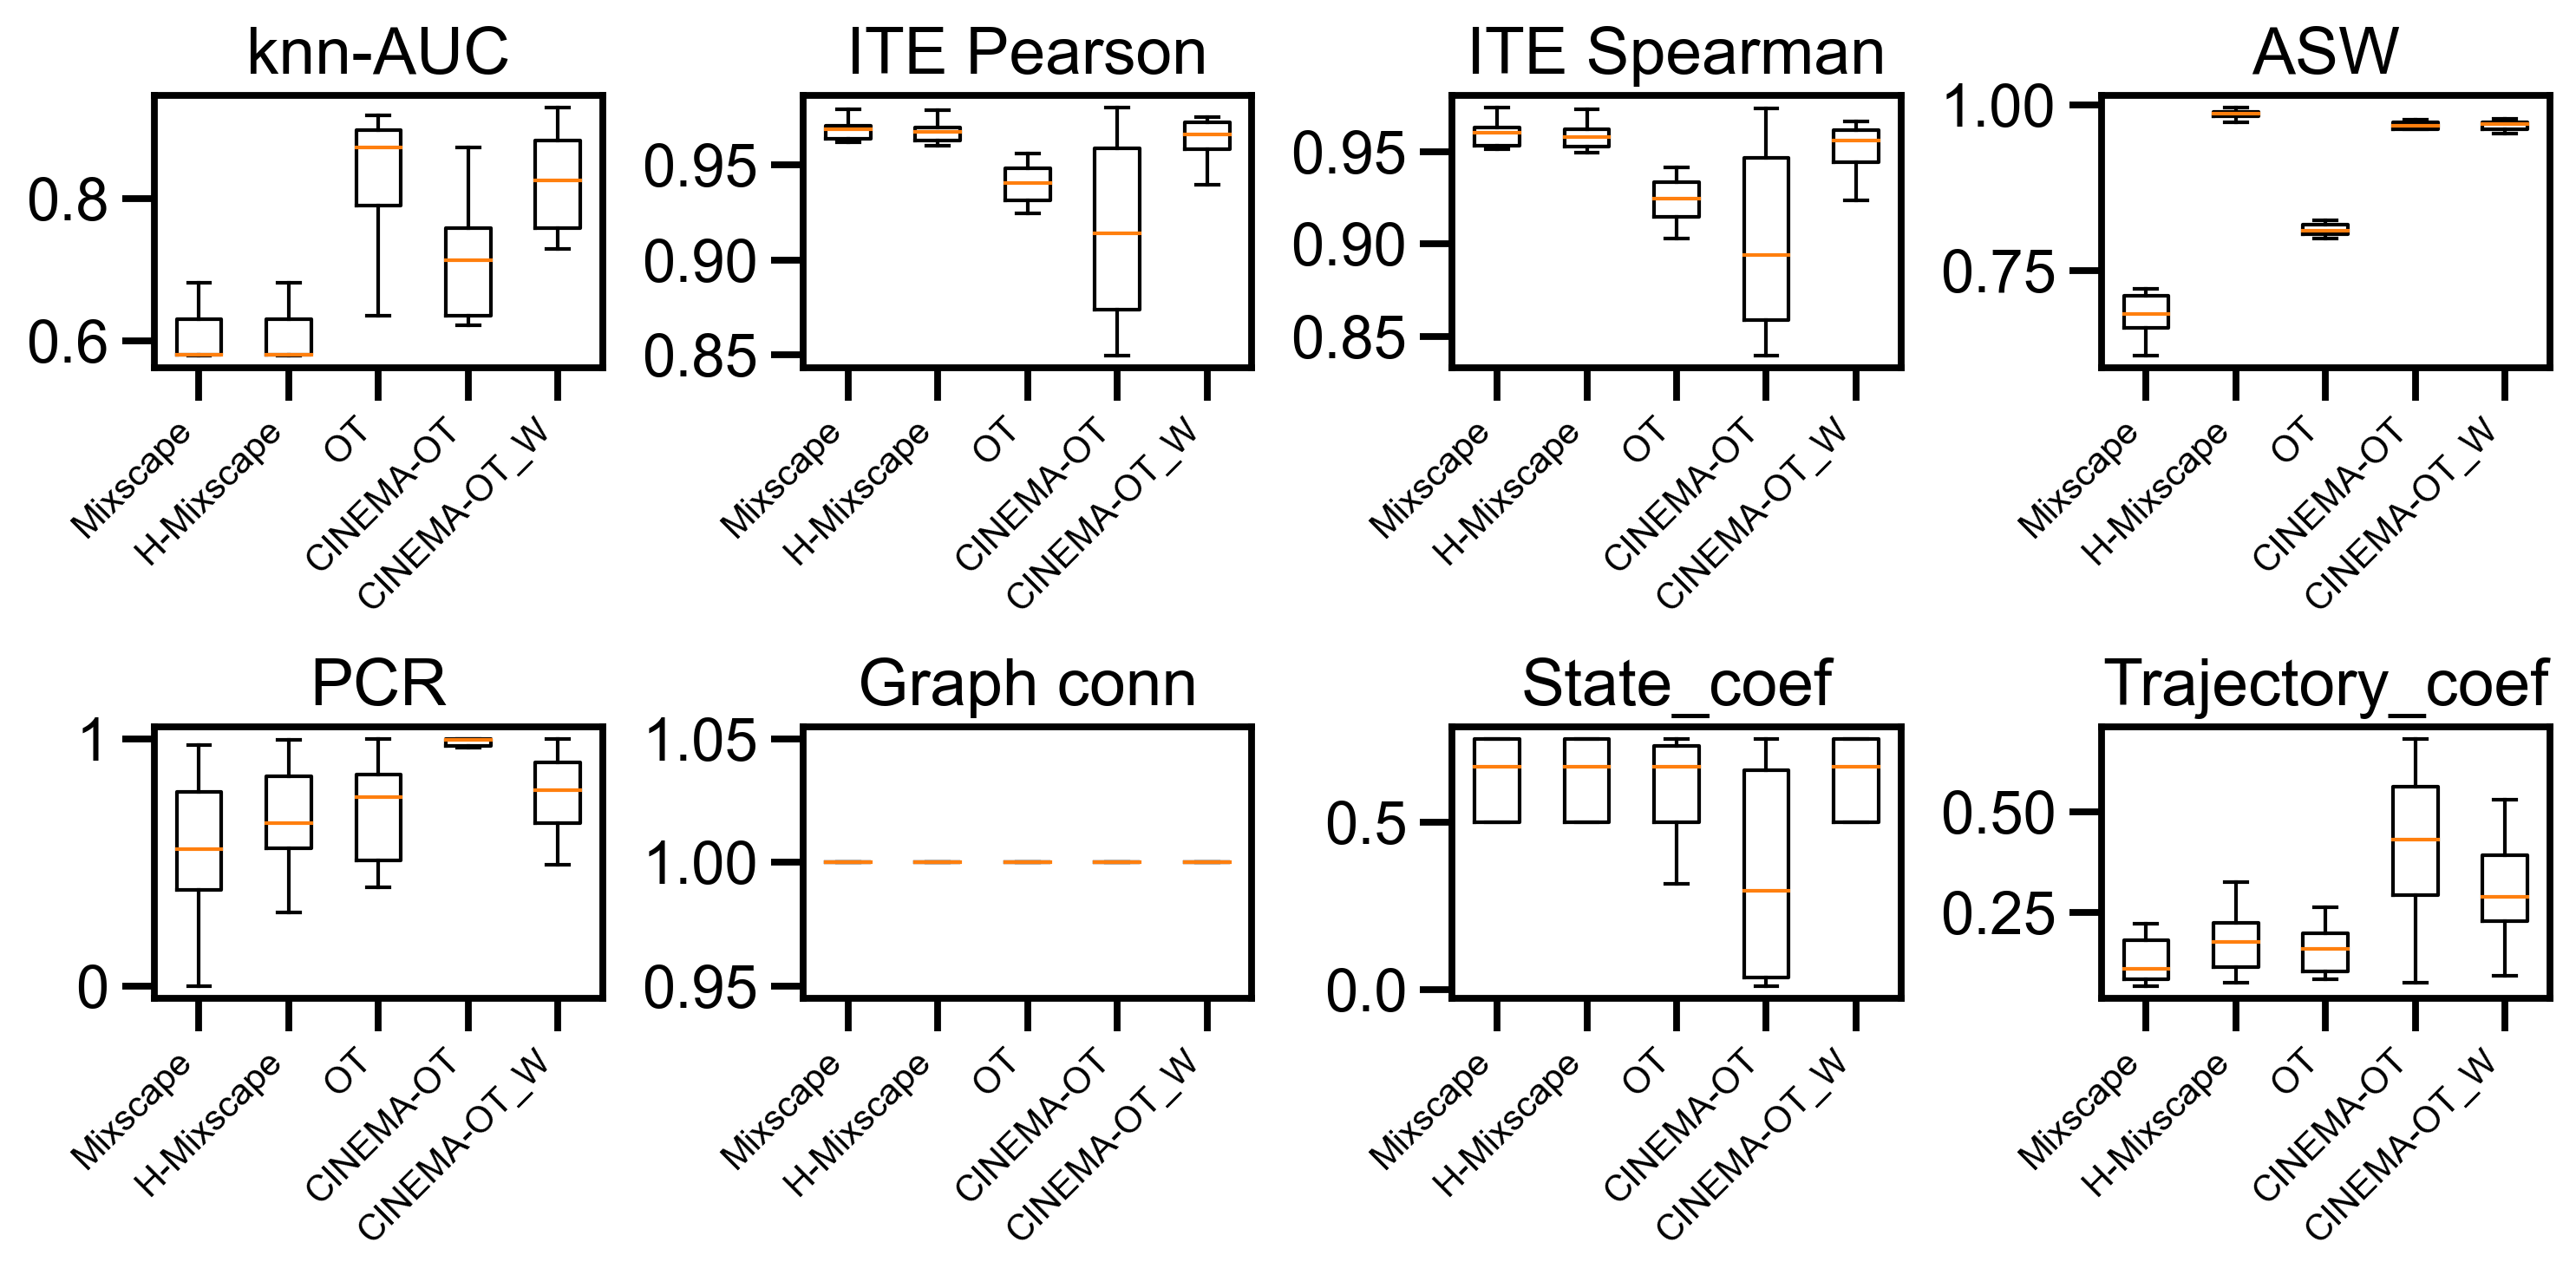

In [21]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = 'Arial'
fig, axs = plt.subplots(2,4, figsize=(10, 5))
axs[0,0].boxplot([auc_mixscape,auc_harmony,auc_OT,auc_cinemaot,auc_wcinemaot],showfliers=False)
axs[0,0].set_xticklabels(['Mixscape','H-Mixscape','OT','CINEMA-OT','CINEMA-OT_W'],fontsize=10,rotation=45, ha='right')
axs[0,0].set_title('knn-AUC')
axs[0,1].boxplot([corr_mixscape,corr_harmony,corr_OT,corr_cinemaot,corr_wcinemaot],showfliers=False)
axs[0,1].set_xticklabels(['Mixscape','H-Mixscape','OT','CINEMA-OT','CINEMA-OT_W'],fontsize=10,rotation=45, ha='right')
axs[0,1].set_title('ITE Pearson')

axs[0,2].boxplot([scorr_mixscape,scorr_harmony,scorr_OT,scorr_cinemaot,scorr_wcinemaot],showfliers=False)
axs[0,2].set_xticklabels(['Mixscape','H-Mixscape','OT','CINEMA-OT','CINEMA-OT_W'],fontsize=10,rotation=45, ha='right')
axs[0,2].set_title('ITE Spearman')

axs[0,3].boxplot([metrics_mixscape.iloc[3,:].values,metrics_harmony.iloc[3,:].values,metrics_OT.iloc[3,:].values,metrics_cinemaot.iloc[3,:].values,metrics_wcinemaot.iloc[3,:].values],showfliers=False)
axs[0,3].set_xticklabels(['Mixscape','H-Mixscape','OT','CINEMA-OT','CINEMA-OT_W'],fontsize=10,rotation=45, ha='right')
axs[0,3].set_title('ASW')
axs[1,0].boxplot([metrics_mixscape.iloc[4,:].values,metrics_harmony.iloc[4,:].values,metrics_OT.iloc[4,:].values,metrics_cinemaot.iloc[4,:].values,metrics_wcinemaot.iloc[4,:].values],showfliers=False)
axs[1,0].set_xticklabels(['Mixscape','H-Mixscape','OT','CINEMA-OT','CINEMA-OT_W'],fontsize=10,rotation=45, ha='right')
axs[1,0].set_title('PCR')
axs[1,1].boxplot([metrics_mixscape.iloc[8,:].values,metrics_harmony.iloc[8,:].values,metrics_OT.iloc[8,:].values,metrics_cinemaot.iloc[8,:].values,metrics_wcinemaot.iloc[8,:].values],showfliers=False)
axs[1,1].set_xticklabels(['Mixscape','H-Mixscape','OT','CINEMA-OT','CINEMA-OT_W'],fontsize=10,rotation=45, ha='right')
axs[1,1].set_title('Graph conn')
axs[1,2].boxplot([metrics_mixscape.loc['states'].values,metrics_harmony.loc['states'].values,metrics_OT.loc['states'].values,metrics_cinemaot.loc['states'].values,metrics_wcinemaot.loc['states'].values],showfliers=False)
axs[1,2].set_xticklabels(['Mixscape','H-Mixscape','OT','CINEMA-OT','CINEMA-OT_W'],fontsize=10,rotation=45, ha='right')
axs[1,2].set_title('State_coef')
axs[1,3].boxplot([metrics_mixscape.loc['steps'].values,metrics_harmony.loc['steps'].values,metrics_OT.loc['steps'].values,metrics_cinemaot.loc['steps'].values,metrics_wcinemaot.loc['steps'].values],showfliers=False)
axs[1,3].set_xticklabels(['Mixscape','H-Mixscape','OT','CINEMA-OT','CINEMA-OT_W'],fontsize=10,rotation=45, ha='right')
axs[1,3].set_title('Trajectory_coef')
fig.tight_layout()

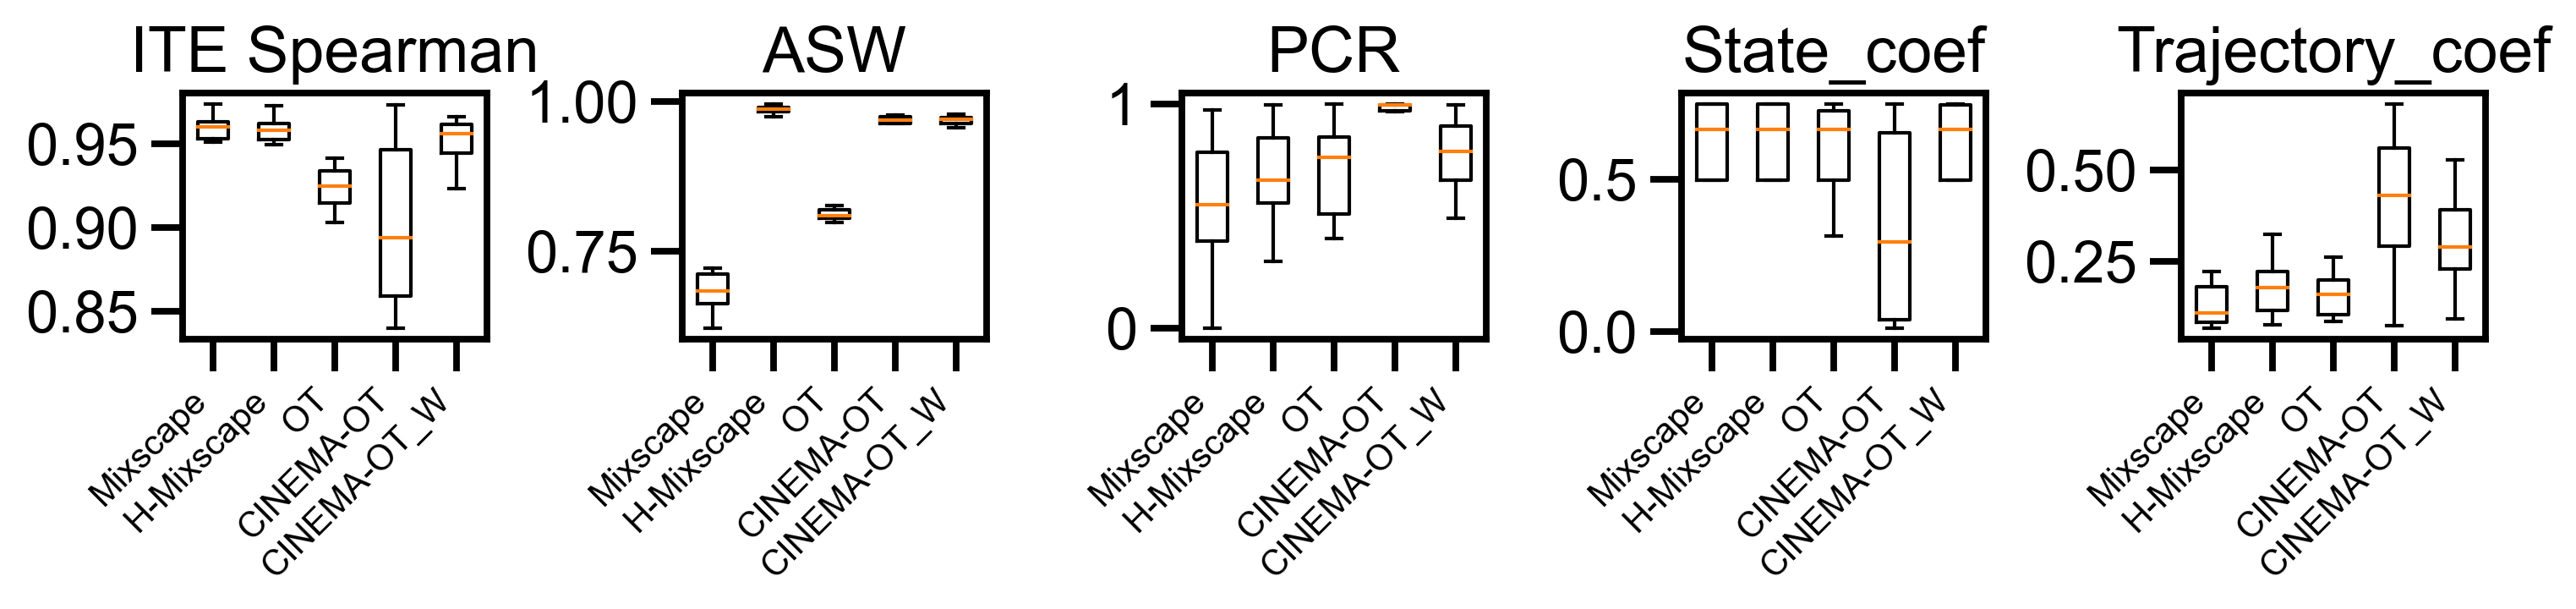

In [14]:

fig, axs = plt.subplots(1,5, figsize=(10, 2.5))

axs[0].boxplot([scorr_mixscape,scorr_harmony,scorr_OT,scorr_cinemaot,scorr_wcinemaot],showfliers=False)
axs[0].set_xticklabels(['Mixscape','H-Mixscape','OT','CINEMA-OT','CINEMA-OT_W'],fontsize=10,rotation=45, ha='right')
axs[0].set_title('ITE Spearman')
axs[1].boxplot([metrics_mixscape.iloc[3,:].values,metrics_harmony.iloc[3,:].values,metrics_OT.iloc[3,:].values,metrics_cinemaot.iloc[3,:].values,metrics_wcinemaot.iloc[3,:].values],showfliers=False)
axs[1].set_xticklabels(['Mixscape','H-Mixscape','OT','CINEMA-OT','CINEMA-OT_W'],fontsize=10,rotation=45, ha='right')
axs[1].set_title('ASW')
axs[2].boxplot([metrics_mixscape.iloc[4,:].values,metrics_harmony.iloc[4,:].values,metrics_OT.iloc[4,:].values,metrics_cinemaot.iloc[4,:].values,metrics_wcinemaot.iloc[4,:].values],showfliers=False)
axs[2].set_xticklabels(['Mixscape','H-Mixscape','OT','CINEMA-OT','CINEMA-OT_W'],fontsize=10,rotation=45, ha='right')
axs[2].set_title('PCR')
axs[3].boxplot([metrics_mixscape.loc['states'].values,metrics_harmony.loc['states'].values,metrics_OT.loc['states'].values,metrics_cinemaot.loc['states'].values,metrics_wcinemaot.loc['states'].values],showfliers=False)
axs[3].set_xticklabels(['Mixscape','H-Mixscape','OT','CINEMA-OT','CINEMA-OT_W'],fontsize=10,rotation=45, ha='right')
axs[3].set_title('State_coef')
axs[4].boxplot([metrics_mixscape.loc['steps'].values,metrics_harmony.loc['steps'].values,metrics_OT.loc['steps'].values,metrics_cinemaot.loc['steps'].values,metrics_wcinemaot.loc['steps'].values],showfliers=False)
axs[4].set_xticklabels(['Mixscape','H-Mixscape','OT','CINEMA-OT','CINEMA-OT_W'],fontsize=10,rotation=45, ha='right')
axs[4].set_title('Trajectory_coef')
fig.tight_layout()

In [20]:
metrics_OT

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
NMI_cluster/label,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ARI_cluster/label,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ASW_label,0.714679,0.726714,0.743812,0.725777,0.545140,0.728510,0.722485,0.716936,0.720758,0.723192,0.696661,0.721550,0.723859,0.722054,0.717027
ASW_label/batch,0.826108,0.798194,0.804280,0.809951,0.754079,0.814473,0.814431,0.805243,0.819237,0.807228,0.819991,0.821015,0.803978,0.819338,0.809190
PCR_batch,0.567079,0.999962,0.763581,0.866471,0.991318,0.572655,0.425435,0.908883,0.400991,0.558439,0.420108,0.781905,0.786260,0.460909,0.841435
cell_cycle_conservation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
isolated_label_F1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
isolated_label_silhouette,0.714679,0.726714,0.743812,0.725777,0.545140,0.659814,0.668713,0.653729,0.649465,0.660526,0.615253,0.616426,0.619536,0.621496,0.617306
graph_conn,1.000000,1.000000,1.000000,1.000000,0.963252,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
kBET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
